In [224]:
import os
import sys

project_root = os.path.abspath("..")  # or path to repo root
sys.path.append(project_root)

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configure visualization settings
plt.style.use('ggplot')
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
file_path = "../data/raw/dataset.csv"

df = pd.read_csv(file_path)
# 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
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,"This will be more of a ''my experience with this game'' type of review, because saying things like ''great gameplay'' will not suit something I've experienced with Counter-Strike. Here you go: I remember back in 2002 I was at a friend's house and he was playing a game. I didn't know the name of the game nor I had internet to find it. A few weeks passed by and another friend came over. He didn't have a computer, so he brought a disc with a game in it. He told me that it was one of the best g...",1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like games that don't lag? • Do you like games you can run on low end PC's? • Do you like games where you don't meet children who have slept with your mother? Then this is for you!,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


# Filter Rows

In [227]:
df["app_name"].isnull().sum()

np.int64(183234)

In [228]:
df = df.dropna(subset=["app_name","review_text"])
df.shape

(6226728, 5)

In [229]:
df = df.drop_duplicates()
df.shape

(4483850, 5)

In [230]:
df['review_word_count'] = df['review_text'].apply(lambda x: len(str(x).split()))

In [ ]:
(df["review_word_count"] < 5).sum()

np.int64(302989)

In [ ]:
df = df[df["review_word_count"] > 5]
df.shape

(4057794, 6)

In [233]:
df = df[df["review_word_count"] > 10]
df.shape

(3462202, 6)

# Filter based on Unique Words Count and Words Count Range 

In [234]:
import re

def count_unique_words(text):
    # lowercase
    text = text.lower()
    # tokenize (letters and numbers)
    words = re.findall(r"\b\w+\b", text)
    return len(set(words))

In [235]:
df["review_unique_word_count"] = df["review_text"].astype(str).apply(count_unique_words)

In [236]:
df["unique_ratio"] = df["review_unique_word_count"] / df["review_word_count"]

In [237]:
df.shape

(3462202, 8)

In [238]:
cutoff = df["unique_ratio"].quantile(0.05)
df = df[df["unique_ratio"] >= cutoff]
df.shape

(3289102, 8)

In [239]:
pd.set_option("display.max_colwidth", 500)
df_long_review = df[df["review_word_count"] > 1000]

In [240]:
df_long_review[df_long_review["review_unique_word_count"] < 10]["app_id"].count()

np.int64(0)

In [241]:
df_long_review.shape[0]

9

In [242]:
df_mid_review = df[(df["review_word_count"] > 500) & (df["review_word_count"] < 1000)]

In [243]:
df_mid_review.shape

(1891, 8)

In [244]:
df_short_review = df[(df["review_word_count"] < 500)]

In [245]:
df_short_review.shape

(3287178, 8)

In [246]:
subset_250_500 = df_short_review[
    (df_short_review["review_word_count"] > 250) &
    (df_short_review["review_word_count"] < 500)
]["review_unique_word_count"].value_counts(ascending=True).sort_index()

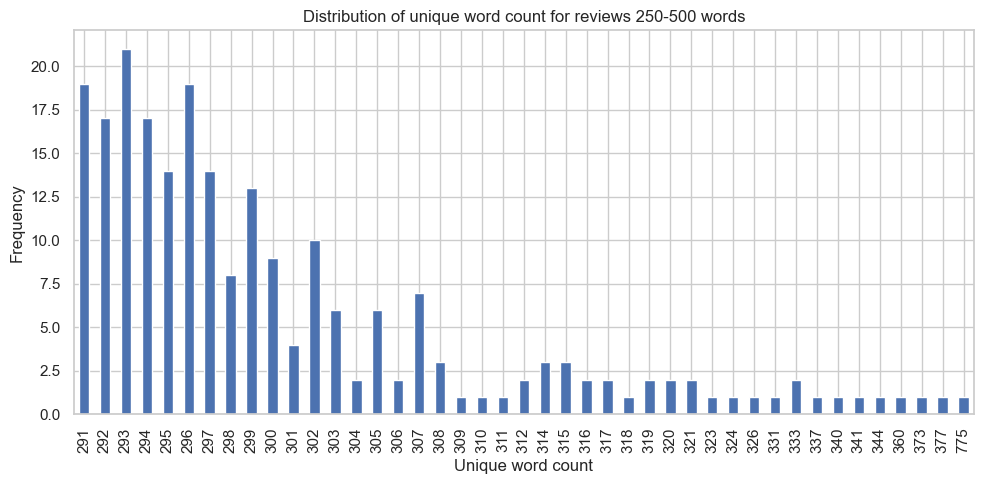

In [247]:
subset_250_500_ranged = subset_250_500.iloc[150:250]

plt.figure(figsize=(10, 5))
subset_250_500_ranged.plot(kind="bar")
plt.xlabel("Unique word count")
plt.ylabel("Frequency")
plt.title("Distribution of unique word count for reviews 250-500 words")
plt.tight_layout()
plt.show()

In [248]:
# Number of unique games
len(df["app_name"].unique())

8526

# Review Votes

In [249]:
df["review_votes"].value_counts()

review_votes
0    2810671
1     478431
Name: count, dtype: int64

In [250]:
count_vote = df.groupby(by="app_name").agg(
    sum_vote=('review_votes','sum'),
    avg_vote=('review_votes', 'mean'),
    num_review=('review_votes','count')
).reset_index()

count_vote[count_vote["sum_vote"] == 0]

,app_name,sum_vote,avg_vote,num_review
51,21 Steps to Soul,0,0.00,2
58,3D Chess,0,0.00,4
83,7 Wonders: Ancient Alien Makeover,0,0.00,40
84,7 Wonders: Magical Mystery Tour,0,0.00,6
104,9Grids VR,0,0.00,3
...,...,...,...,...
8396,Zenerchi,0,0.00,4
8410,Zeus Quest Remastered,0,0.00,1
8466,bloxyz,0,0.00,3
8489,iPi Recorder 2,0,0.00,4


In [252]:
df = df[df["review_votes"] == 1]

# Stratified Sampling

In [256]:
N = 10

sampled = (
    df
    .groupby(["app_name", "review_score"])
    .apply(lambda g: g.sample(n=min(N, len(g)), random_state=42))
    .reset_index(drop=True)
)

In [257]:
sampled.shape

(90559, 8)

In [258]:
len(sampled["app_name"].unique())

8065

In [211]:
sampled.groupby("app_name")["app_id"].count().sort_values(ascending=False)

app_name
10 Second Ninja                             40
侠客风云传(Tale of Wuxia)                        40
theHunter: Primal                           40
theHunter Classic                           40
the static speaks my name                   40
                                            ..
Zipple World 2: The Sweet Chaos              1
A Week of Circus Terror                      1
Project Hovercraft                           1
Hover Hazard                                 1
Professor Teaches® PowerPoint 2013 & 365     1
Name: app_id, Length: 8526, dtype: int64

In [68]:
pd.set_option("display.max_colwidth", 100)
sampled

,app_id,app_name,review_text,review_score,review_votes,review_word_count
0,490390,神明的一天世界-God's One Day World,this visual novel contains puzzle that will confuse you. there are alot of cons in this game tha...,-1,1,218
1,490390,神明的一天世界-God's One Day World,I replayed the game recently and realised that the games grammar and translation needs some seri...,-1,0,75
2,490390,神明的一天世界-God's One Day World,First real visual novel type game I've played and I enjoyed it a lot. The story is really intere...,1,0,87
3,490390,神明的一天世界-God's One Day World,It looks like a galgame. but indeed it's a attractive puzzle game. If some details can handle b...,1,1,57
4,490390,神明的一天世界-God's One Day World,This is not a 'game' or well you can really consider this as a game as there are choice which wi...,1,0,331
...,...,...,...,...,...,...
229862,554640,拯救大魔王2 Rescue the Great Demon 2,the translation was so bad i played it in chinese. i am sure i can get lesser spelling errors th...,1,1,35
229863,554640,拯救大魔王2 Rescue the Great Demon 2,"Just like the tatoo I got on my 18th Birthday, Bravery: 鸡汤",1,1,12
229864,554640,拯救大魔王2 Rescue the Great Demon 2,overall good game except for the translation. Really need to fix the bug which causes saved game...,1,0,27
229865,554640,拯救大魔王2 Rescue the Great Demon 2,"Has a few bugs such as mixing english and japanese languages during some events in the game, som...",1,0,40
